In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-24 14:03:17.792214: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-24 14:03:18.621545: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3596253734649682340,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32477282304
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14537695144447707883
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

In [3]:
import os
print(os.listdir('./data/Flowers299'))

['Kniphofia', 'ForgetMeNot', 'Zinnia', 'IcelandPoppy', 'Pinks', 'Alchemilla', 'Lavatera', 'Nemophila', 'Linaria', 'Penstemon', 'Celosia', 'Phlox', 'FlannelFlower', 'Clover', 'Dahlia', 'Magnolia', 'Impatiens', 'Clematis', 'Mayflower', 'BabyтАЩsBreath', 'Lupin', 'TeaRose', 'Hosta', 'PersianButtercup', 'PaintedDaisy', 'Bluebonnets', 'ShastaDaisy', 'Geranium', 'Eremurus', 'Heliotrope', 'Photinia', 'Cornflower', 'RockRose', 'Viburnum', 'Hibiscus', 'Snowdrop', 'Silene', 'Dianella', 'Broom', 'Parodia', 'Xerophyllum', 'Quince', 'OrientalPoppy', 'Pansy', 'Columbine', 'Verbena', 'Helenium', 'Candytuft', 'WaxPlant', 'ArmeriaMaritima', 'Chrysanthemum', 'Bergamot', 'Lotus', 'LadyтАЩsSlipper', 'Sage', 'Marigold', 'TigerFlower', 'PincushionFlower', 'Alstroemeria', 'Sedum', 'PeaceLily', 'BalloonFlower', 'CaliforniaPoppy', 'LemonVerbena', 'Sunflower', 'MorningGlory', 'Bouvardia', 'Corydalis', 'PowderPuff', 'PassionFlower', 'Wedelia', 'Winterberry', 'CrownImperial', 'Bellflower', 'Feverfew', 'Clarkia', 

In [4]:
batch_size = 32
img_height = 160
img_width = 160
img_size = (img_height, img_width)

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './data/Flowers299',
  validation_split = 0.2,
  subset = "training",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 115944 files belonging to 299 classes.
Using 92756 files for training.


2022-01-24 14:03:24.875990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30972 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './data/Flowers299',
  validation_split = 0.2,
  subset = "validation",
  seed=123,
  image_size=img_size,
  batch_size=batch_size)

Found 115944 files belonging to 299 classes.
Using 23188 files for validation.


2022-01-24 14:03:31.635750: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


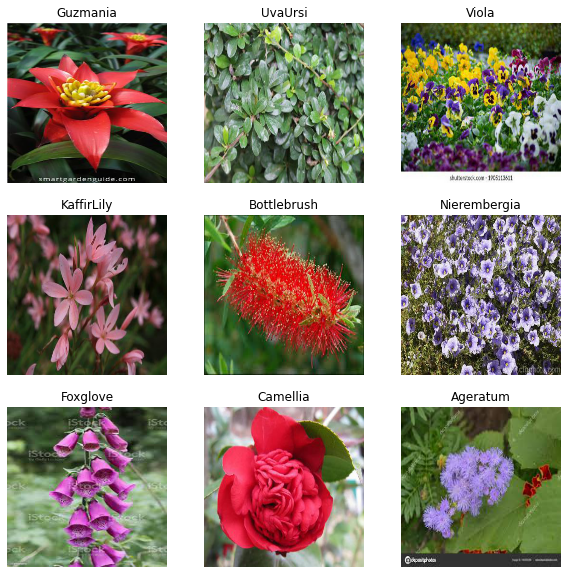

In [7]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

In [9]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 580
Number of test batches: 145


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_ds.prefetch(buffer_size=AUTOTUNE)

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

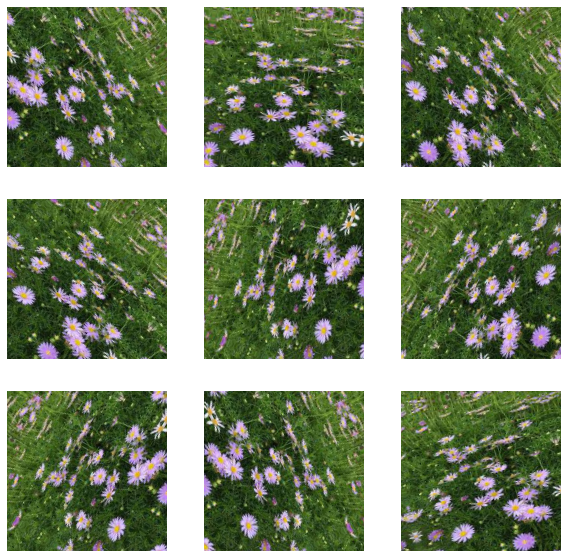

In [12]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [15]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [16]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2022-01-24 14:03:36.186078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


(32, 5, 5, 1280)


In [17]:
base_model.trainable = False


In [18]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [19]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [20]:
prediction_layer = tf.keras.layers.Dense(299)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 299)


In [21]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [22]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=1e-6)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy'])


/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [23]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [24]:
len(model.trainable_variables)

2

In [25]:
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 3, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)

earlystop = EarlyStopping(patience=10)

# 가중치 저장을 위한 checkpoint 만들기 
checkpoint_path = "training1/cp3.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


callbacks = [earlystop, learning_rate_reduction, cp_callback]

In [26]:
history = model.fit_generator(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=50,
                    callbacks = [callbacks]
                                                  )

/home/c4nd0it/anaconda3/envs/keras_env/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
2899/2899 [==============================] - 55s 18ms/step - loss: 12.4576 - sparse_categorical_accuracy: 0.0037 - val_loss: 12.1753 - val_sparse_categorical_accuracy: 0.0027

Epoch 00001: saving model to training1/cp3.ckpt
Epoch 2/50
2899/2899 [==============================] - 52s 18ms/step - loss: 12.3417 - sparse_categorical_accuracy: 0.0034 - val_loss: 12.0426 - val_sparse_categorical_accuracy: 0.0028

Epoch 00002: saving model to training1/cp3.ckpt
Epoch 3/50
2899/2899 [==============================] - 51s 18ms/step - loss: 12.2477 - sparse_categorical_accuracy: 0.0034 - val_loss: 11.8987 - val_sparse_categorical_accuracy: 0.0026

Epoch 00003: saving model to training1/cp3.ckpt
Epoch 4/50
2899/2899 [==============================] - 51s 17ms/step - loss: 12.0773 - sparse_categorical_accuracy: 0.0038 - val_loss: 11.7779 - val_sparse_categorical_accuracy: 0.0030

Epoch 00004: saving model to training1/cp3.ckpt
Epoch 5/50
2899/2899 [==============================] - 51s 

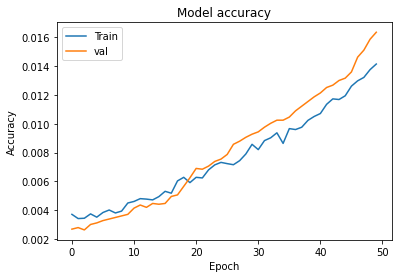

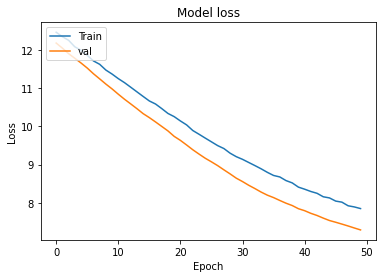

In [27]:
epoch_range = range(0, 50)
plt.plot(epoch_range, history.history['sparse_categorical_accuracy'])
plt.plot(epoch_range, history.history['val_sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'val'], loc='upper left')
plt.show()

In [28]:
base_model.trainable = True

In [29]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [30]:
opt = Adam(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['sparse_categorical_accuracy'])

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [32]:
len(model.trainable_variables)

56

In [33]:
from keras.callbacks import EarlyStopping , ReduceLROnPlateau

learning_rate_reduction=ReduceLROnPlateau(
                        monitor= "val_loss", 
                        patience = 3, 
                        factor = 0.5, 
                        min_lr=0.0001,
                        verbose=1)

earlystop = EarlyStopping(patience=50)

# 가중치 저장을 위한 checkpoint 만들기 
checkpoint_path = "training1/cp4.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# 모델의 가중치를 저장하는 콜백 만들기
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


callbacks = [earlystop, learning_rate_reduction, cp_callback]

In [37]:
initial_epochs = 50
fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs
history_fine = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs = total_epochs,
                    initial_epoch=history.epoch[-1],
                    callbacks = [callbacks])

Epoch 50/100
2899/2899 [==============================] - 67s 22ms/step - loss: 5.8569 - sparse_categorical_accuracy: 0.0033 - val_loss: 5.7004 - val_sparse_categorical_accuracy: 0.0037

Epoch 00050: saving model to training1/cp4.ckpt
Epoch 51/100
2899/2899 [==============================] - 64s 22ms/step - loss: 5.7004 - sparse_categorical_accuracy: 0.0032 - val_loss: 5.7004 - val_sparse_categorical_accuracy: 0.0037

Epoch 00051: saving model to training1/cp4.ckpt
Epoch 52/100
2899/2899 [==============================] - 64s 22ms/step - loss: 5.7004 - sparse_categorical_accuracy: 0.0031 - val_loss: 5.7004 - val_sparse_categorical_accuracy: 0.0037

Epoch 00052: saving model to training1/cp4.ckpt
Epoch 53/100
2899/2899 [==============================] - 65s 22ms/step - loss: 5.7004 - sparse_categorical_accuracy: 0.0033 - val_loss: 5.7004 - val_sparse_categorical_accuracy: 0.0037

Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00053: saving model t

KeyboardInterrupt: 

## 실패~~~~~~~~~~~~~~~~~~~~~~~~